#Profile Submission

> Nama : Hamidan Z Wijasena

> Email : hamidanzaneddinewijasena@gmail.com


#Submission-NLP: Klasifikasi Teks pada Dataset BBC News menggunakan metode LSTM
Requirements 

1. Dataset yang akan dipakai bebas, namun minimal memiliki 1000 sampel. 
2. Harus menggunakan LSTM dalam arsitektur model.
3. Harus menggunakan model sequential.
4. Harus menggunakan Embedding.
5. Validation set sebesar 20% dari total dataset.
6. Harus menggunakan fungsi tokenizer. 
7. Akurasi dari model 80%
8. Mengimplementasikan callback.
9. Membuat plot loss dan akurasi pada saat training dan validation.

> Dataset : https://www.kaggle.com/hgultekin/bbcnewsarchive


In [1]:
#Import dataset dari gdrive

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# Import Library yang akan digunakan

import pandas as pd
import nltk, os, re, string
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

In [3]:
# Import Dataset BBCNews

dataframe = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Latihan/NLP/bbc-news-data.csv', sep='\t')
dataframe.head(11)

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
5,business,006.txt,Japan narrowly escapes recession,Japan's economy teetered on the brink of a te...
6,business,007.txt,Jobs growth still slow in the US,The US created fewer jobs than expected in Ja...
7,business,008.txt,India calls for fair trade rules,"India, which attends the G7 meeting of seven ..."
8,business,009.txt,Ethiopia's crop production up 24%,Ethiopia produced 14.27 million tonnes of cro...
9,business,010.txt,Court rejects $280bn tobacco case,A US government claim accusing the country's ...


In [4]:
# Total data

dataframe.shape

(2225, 4)

In [5]:
dataframe.category.value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


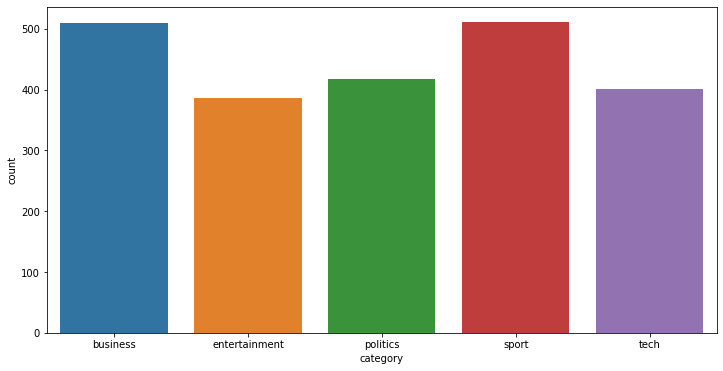

In [6]:
# PLot persebaran data

plt.figure(figsize = (12, 6))
sns.countplot(dataframe.category)

In [7]:
# Hapus kolom yang tidak digunakan

dataframe = dataframe.drop(columns = ['filename'])
dataframe.head(11)

,category,title,content
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
5,business,Japan narrowly escapes recession,Japan's economy teetered on the brink of a te...
6,business,Jobs growth still slow in the US,The US created fewer jobs than expected in Ja...
7,business,India calls for fair trade rules,"India, which attends the G7 meeting of seven ..."
8,business,Ethiopia's crop production up 24%,Ethiopia produced 14.27 million tonnes of cro...
9,business,Court rejects $280bn tobacco case,A US government claim accusing the country's ...


#Pre-Processing Dataset

### https://www.kdnuggets.com/2019/04/text-preprocessing-nlp-machine-learning.html

In [8]:
# lowercasing

dataframe.title = dataframe.title.apply(lambda x: x.lower())
dataframe.content = dataframe.content.apply(lambda x: x.lower())

In [9]:
# Menghapus tanda baca

def cleaner(data):
    return(data.translate(str.maketrans('','', string.punctuation)))
    dataframe.title = dataframe.title.apply(lambda x: cleaner(x))
    dataframe.content = dataframe.content.apply(lambda x: lem(x))

In [10]:
# Menghapus angka

def rem_numbers(data):
    return re.sub('[0-9]+','',data)
    dataframe['title'].apply(rem_numbers)
    dataframe['content'].apply(rem_numbers)

In [11]:
# Lematization

lemmatizer = WordNetLemmatizer()

def lem(data):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(data.split())]))
    dataframe.title = dataframe.title.apply(lambda x: lem(x))
    dataframe.content = dataframe.content.apply(lambda x: lem(x))

In [12]:
# Menghapus stopword

st_words = stopwords.words('english')
def stopword(data):
    return(' '.join([w for w in data.split() if w not in st_words ]))
    dataframe.title = dataframe.title.apply(lambda x: stopword(x))
    dataframe.content = dataframe.content.apply(lambda x: lem(x))

In [13]:
dataframe.head(11)

,category,title,content
0,business,ad sales boost time warner profit,quarterly profits at us media giant timewarne...
1,business,dollar gains on greenspan speech,the dollar has hit its highest level against ...
2,business,yukos unit buyer faces loan claim,the owners of embattled russian oil giant yuk...
3,business,high fuel prices hit ba's profits,british airways has blamed high fuel prices f...
4,business,pernod takeover talk lifts domecq,shares in uk drinks and food firm allied dome...
5,business,japan narrowly escapes recession,japan's economy teetered on the brink of a te...
6,business,jobs growth still slow in the us,the us created fewer jobs than expected in ja...
7,business,india calls for fair trade rules,"india, which attends the g7 meeting of seven ..."
8,business,ethiopia's crop production up 24%,ethiopia produced 14.27 million tonnes of cro...
9,business,court rejects $280bn tobacco case,a us government claim accusing the country's ...


In [14]:
# One-hot-encoding

category = pd.get_dummies(dataframe.category)
dataframe = pd.concat([dataframe, category], axis = 1)
dataframe = dataframe.drop(columns = 'category')
dataframe.head(11)

,title,content,business,entertainment,politics,sport,tech
0,ad sales boost time warner profit,quarterly profits at us media giant timewarne...,1,0,0,0,0
1,dollar gains on greenspan speech,the dollar has hit its highest level against ...,1,0,0,0,0
2,yukos unit buyer faces loan claim,the owners of embattled russian oil giant yuk...,1,0,0,0,0
3,high fuel prices hit ba's profits,british airways has blamed high fuel prices f...,1,0,0,0,0
4,pernod takeover talk lifts domecq,shares in uk drinks and food firm allied dome...,1,0,0,0,0
5,japan narrowly escapes recession,japan's economy teetered on the brink of a te...,1,0,0,0,0
6,jobs growth still slow in the us,the us created fewer jobs than expected in ja...,1,0,0,0,0
7,india calls for fair trade rules,"india, which attends the g7 meeting of seven ...",1,0,0,0,0
8,ethiopia's crop production up 24%,ethiopia produced 14.27 million tonnes of cro...,1,0,0,0,0
9,court rejects $280bn tobacco case,a us government claim accusing the country's ...,1,0,0,0,0


In [15]:
# Ubah nilai pada dataframe menjadi numpy array

news = dataframe['title'].values + '' + dataframe['content'].values
label = dataframe[['business', 'entertainment', 'politics', 'sport', 'tech']].values

label

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=uint8)

In [16]:
# Split data menjadi data training dan data validation

news_train, news_test, label_train, label_test = train_test_split(news, label, test_size=0.2, shuffle=True)

In [17]:
# Tokenizer
 
tokenizer = Tokenizer(num_words=5000, oov_token='x', filters='!"#$%&()*+,-./:;<=>@[\]^_`{|}~ ')
tokenizer.fit_on_texts(news_train) 
tokenizer.fit_on_texts(news_test)
 
sekuens_train = tokenizer.texts_to_sequences(news_train)
sekuens_test = tokenizer.texts_to_sequences(news_test)
 
padded_train = pad_sequences(sekuens_train) 
padded_test = pad_sequences(sekuens_test)

# Model Building 

In [18]:
# Model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=64),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy',)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          320000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 3

In [19]:
# Callback

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.90 and logs.get('val_accuracy')>0.85):
      self.model.stop_training = True
      print("\nThe accuracy of the training set has reached > 90% and the validation set has reached > 85%!")
callbacks = myCallback()

In [20]:
# Model Fit

history = model.fit(padded_train, label_train, epochs = 200, 
                    validation_data = (padded_test, label_test), 
                    verbose = 1, callbacks = [callbacks], validation_steps = 20)

Epoch 1/200
56/56 [==============================] - 15s 226ms/step - loss: 1.5921 - accuracy: 0.2489 - val_loss: 1.5232 - val_accuracy: 0.3618
Epoch 2/200
56/56 [==============================] - 13s 241ms/step - loss: 1.2623 - accuracy: 0.3843 - val_loss: 1.0072 - val_accuracy: 0.4944
Epoch 3/200
56/56 [==============================] - 14s 242ms/step - loss: 1.0330 - accuracy: 0.4416 - val_loss: 1.0652 - val_accuracy: 0.4966
Epoch 4/200
56/56 [==============================] - 13s 228ms/step - loss: 0.9210 - accuracy: 0.5202 - val_loss: 0.9576 - val_accuracy: 0.5371
Epoch 5/200
56/56 [==============================] - 13s 228ms/step - loss: 0.9610 - accuracy: 0.6084 - val_loss: 0.8963 - val_accuracy: 0.6472
Epoch 6/200
56/56 [==============================] - 13s 226ms/step - loss: 0.5699 - accuracy: 0.7506 - val_loss: 0.6341 - val_accuracy: 0.7506
Epoch 7/200
56/56 [==============================] - 14s 245ms/step - loss: 0.3378 - accuracy: 0.8539 - val_loss: 0.6475 - val_accuracy:

# Model Evaluation

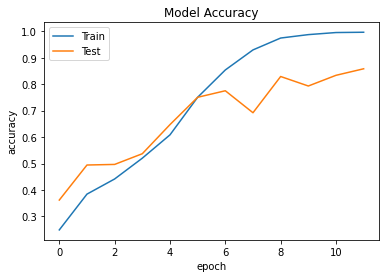

In [21]:
# Plot Accuracy

import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

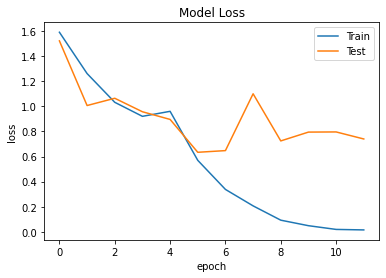

In [22]:
# Plot Loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()